[link text](https://)<h2><center> <font color='black'> Node Embeddings</font></center>


Graph embedding is an approach that is used to transform nodes, edges, and their features into vector space (a lower dimension) whilst maximally preserving properties like graph structure and information.<br>

DeepWalk is an algorithm that is used to create embeddings of the nodes in a graph. The embeddings are meant to encode the community structure of the graph. It achieves this by using SkipGram to create the embeddings. It uses short random walks to learn representations for vertices in graphs.DeepWalk implementation - https://github.com/prateekjoshi565/DeepWalk, http://www.perozzi.net/projects/deepwalk/<br>

In this notebook, we will explore how to use DeepWalk, a popular algorithm for generating node embeddings, on a well-known social network graph: Zachary's Karate Club.


## Setup

**We need the following libraries: networkx, Word2Vec, PCA**

In [35]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [36]:
!pip install word2vec

## Creation of graph

We'll be using the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Zach's Karate Club is a classic case study in network analysis and social dynamics. It represents the social structure of a karate club studied by Wayne W. Zachary in the 1970s. The study tracked the relationships among the club's members and their alignment with either the club’s instructor or its administrator during a conflict that ultimately led to the club splitting into two factions.

In [37]:
G = nx.karate_club_graph()

In [38]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

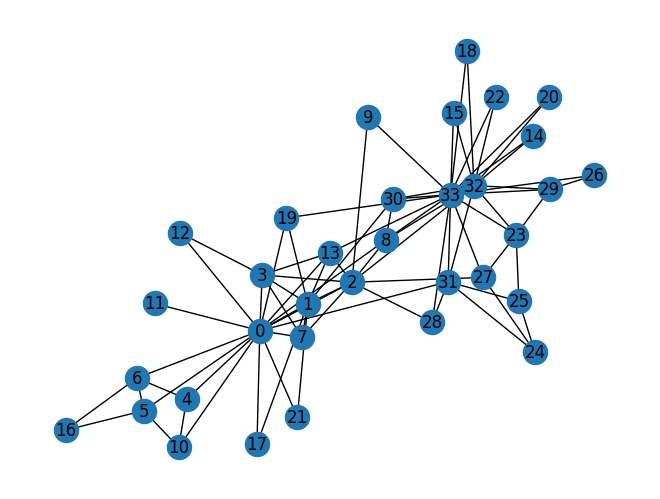

In [39]:
nx.draw(G, with_labels = True)

Let's explore the graph and print out a few statisitics

In [40]:
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = round(num_edges * 2 / num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


In [41]:
avg_cluster_coef = round(nx.average_clustering(G), 2)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## 1.1 Deep Walk Basics

### Random Walk

In [42]:
def get_random_walk(node, walk_length):

    random_walk_length = [node]
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):

        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then do not add them as new neighbors


        # neighbors = list(set(neighbors) - set(random_walk_length)) #WARNING: Uncommenting this line of code will remove multi-set neighborhoods

        if len(neighbors) == 0:
            break

        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor

    return random_walk_length

In [43]:
# check random walk for node '2'
get_random_walk(2, 10)

[2, 1, 7, 2, 8, 2, 28, 2, 9, 2]

In [44]:
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))

100%|██████████| 34/34 [00:00<00:00, 7624.78it/s]


In [45]:
len(random_walks)

170

In [46]:
random_walks[0]

[0, 5, 6, 16, 5, 16, 6, 0, 13, 33]

In [47]:
random_walks[1]

[0, 11, 0, 3, 13, 2, 9, 2, 8, 33]

In [48]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)

In [49]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(7137, 34000)

In [50]:
print(model)

Word2Vec<vocab=34, vector_size=100, alpha=0.03>


## Most similar nodes

In [51]:
# most similar nodes to node '1'
for node, _ in model.wv.most_similar(1):
    print((node, _))

(21, 0.9981345534324646)
(3, 0.9974948167800903)
(7, 0.9974437355995178)
(11, 0.9974296689033508)
(13, 0.9972719550132751)
(12, 0.9972332715988159)
(17, 0.9971729516983032)
(0, 0.9957485198974609)
(4, 0.9954298734664917)
(19, 0.995395302772522)


## 1.2 Visualization of DeepWalk Embeddings

In [52]:
def plot_nodes(word_list):
    X = model.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

In [53]:
numbers = list(G.nodes)

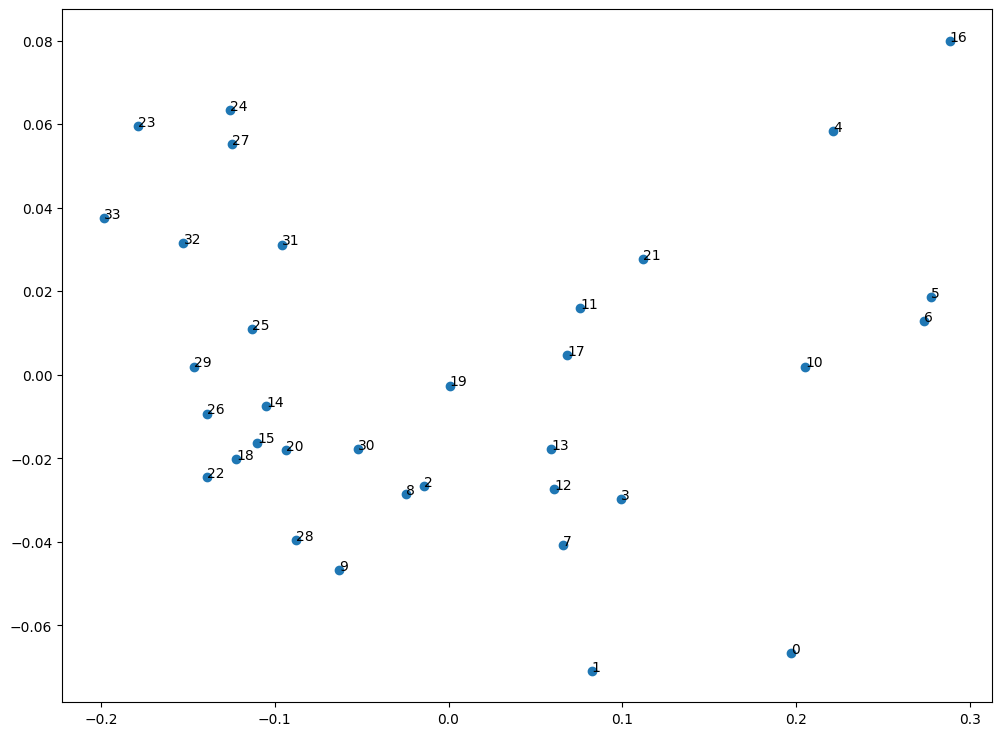

In [54]:
plot_nodes(numbers)

In [55]:
!pip install node2vec
import seaborn as sns
from sklearn.manifold import TSNE
from node2vec import Node2Vec  # For comparison
import networkx.algorithms.community as nx_comm


In [56]:
# Add more interesting datasets
from networkx.generators import watts_strogatz_graph, barabasi_albert_graph


In [57]:
def load_example_graphs():
    # Social Networks
    karate = nx.karate_club_graph()

    # Scientific Collaboration Network (subset of arXiv)
    collab = nx.davis_southern_women_graph()

    # Synthetic Networks
    small_world = watts_strogatz_graph(100, 4, 0.1)
    scale_free = barabasi_albert_graph(100, 3)

    return {
        "Karate Club": karate,
        "Collaboration": collab,
        "Small World": small_world,
        "Scale Free": scale_free
    }


In [58]:
def plot_embeddings_with_communities(G, embeddings, title=""):
    # Detect communities
    communities = nx_comm.greedy_modularity_communities(G)

    # Create color map
    color_map = []
    for node in G.nodes():
        for idx, comm in enumerate(communities):
            if node in comm:
                color_map.append(sns.color_palette()[idx])
                break

    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings = np.array([embeddings[str(node)] for node in G.nodes()])
    node_embeddings_2d = tsne.fit_transform(node_embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
                         c=color_map, alpha=0.7)

    # Add node labels
    for i, node in enumerate(G.nodes()):
        plt.annotate(node, (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

    plt.title(f"DeepWalk Embeddings - {title}")
    plt.show()

In [59]:
class DeepWalk:
    def __init__(self, window_size=4, embedding_size=128, walks_per_node=10,
                 walk_length=10, workers=1):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walks_per_node = walks_per_node
        self.walk_length = walk_length
        self.workers = workers

    def generate_walks(self, G):
        walks = []
        nodes = list(G.nodes())

        for _ in tqdm(range(self.walks_per_node), desc="Generating walks"):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self._random_walk(G, node))

        return walks

    def _random_walk(self, G, start_node):
        walk = [start_node]
        for _ in range(self.walk_length - 1):
            current = walk[-1]
            neighbors = list(G.neighbors(current))
            if neighbors:
                walk.append(random.choice(neighbors))
            else:
                break
        return [str(node) for node in walk]

    def train(self, G):
        walks = self.generate_walks(G)
        model = Word2Vec(
            walks,
            vector_size=self.embedding_size,
            window=self.window_size,
            min_count=0,
            sg=1,
            workers=self.workers,
            epochs=5
        )
        return model



In [60]:
def analyze_embeddings(G, embeddings):
    # Compute clustering preservation
    orig_clustering = nx.clustering(G)
    emb_distances = {}

    nodes = list(G.nodes())
    for n1 in nodes:
        for n2 in nodes:
            if n1 != n2:
                emb_distances[(n1, n2)] = np.linalg.norm(
                    embeddings[str(n1)] - embeddings[str(n2)]
                )

    # Print statistics
    print("=== Embedding Analysis ===")
    print(f"Number of dimensions: {embeddings.vector_size}")
    print(f"Number of nodes: {len(G.nodes())}")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")


In [61]:
def demonstrate_link_prediction(G, embeddings):
    # Remove some edges for testing
    edges = list(G.edges())
    np.random.shuffle(edges)
    test_edges = edges[:int(len(edges) * 0.1)]

    # Create training graph
    G_train = G.copy()
    G_train.remove_edges_from(test_edges)

    # Predict links
    predictions = []
    for n1, n2 in test_edges:
        similarity = np.dot(embeddings[str(n1)], embeddings[str(n2)])
        predictions.append((similarity, (n1, n2)))

    # Evaluate
    predictions.sort(reverse=True)
    correct = sum(1 for _, edge in predictions[:len(test_edges)] if edge in test_edges)
    print(f"Link prediction accuracy: {correct/len(test_edges):.3f}")


In [62]:
!pip install --quiet umap-learn[plot]

In [63]:
# Add new imports
import umap
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import spearmanr


In [64]:
class GraphVisualizer:
    @staticmethod
    def plot_graph_properties(G, title=""):
        """Visualize basic graph properties"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        fig.suptitle(f"Graph Properties: {title}", fontsize=16)

        # Degree distribution
        degrees = [d for n, d in G.degree()]
        sns.histplot(degrees, ax=axes[0,0])
        axes[0,0].set_title("Degree Distribution")

        # Clustering coefficient distribution
        clustering = list(nx.clustering(G).values())
        sns.histplot(clustering, ax=axes[0,1])
        axes[0,1].set_title("Clustering Coefficient Distribution")

        # Network visualization with spring layout
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, ax=axes[1,0], node_size=100, node_color='lightblue')
        axes[1,0].set_title("Network Visualization")

        # Shortest path length distribution
        path_lengths = []
        for u in list(G.nodes())[:100]:  # Sample for efficiency
            for v in list(G.nodes())[:100]:
                if u != v:
                    try:
                        path_lengths.append(nx.shortest_path_length(G, u, v))
                    except:
                        continue
        sns.histplot(path_lengths, ax=axes[1,1])
        axes[1,1].set_title("Shortest Path Length Distribution")

        plt.tight_layout()
        plt.show()


In [65]:
class EmbeddingComparator:
    def __init__(self, G):
        self.G = G
        self.embedding_methods = {
            'DeepWalk': self._get_deepwalk_embeddings,
            'Node2Vec': self._get_node2vec_embeddings,
            'LaplacianEigenmaps': self._get_laplacian_embeddings
        }

    def _get_deepwalk_embeddings(self):
        dw = DeepWalk(embedding_size=128)
        model = dw.train(self.G)
        return np.array([model.wv[str(node)] for node in self.G.nodes()])

    def _get_node2vec_embeddings(self):
        node2vec = Node2Vec(self.G, dimensions=128, walk_length=30, num_walks=200)
        model = node2vec.fit()
        return np.array([model.wv[str(node)] for node in self.G.nodes()])

    def _get_laplacian_embeddings(self):
        L = nx.normalized_laplacian_matrix(self.G)
        eigenvals, eigenvecs = np.linalg.eigh(L.toarray())
        return eigenvecs[:, 1:129]  # Skip first eigenvalue

    def compare_embeddings(self):
        embeddings = {}
        for name, method in self.embedding_methods.items():
            embeddings[name] = method()

        # Compare embeddings using different dimensionality reduction techniques
        reduction_methods = {
            'PCA': PCA(n_components=2),
            'TSNE': TSNE(n_components=2),
            'UMAP': umap.UMAP(n_components=2)
        }

        fig = plt.figure(figsize=(20, 15))
        idx = 1

        for emb_name, emb_matrix in embeddings.items():
            for red_name, reducer in reduction_methods.items():
                plt.subplot(len(embeddings), len(reduction_methods), idx)

                # Reduce dimensionality
                reduced_emb = reducer.fit_transform(StandardScaler().fit_transform(emb_matrix))

                # Plot with communities
                communities = nx_comm.greedy_modularity_communities(self.G)

                # Create a node-to-index mapping
                node_to_idx = {node: i for i, node in enumerate(self.G.nodes())}

                # Initialize colors list with the correct length
                colors = [0] * len(self.G)

                # Assign colors based on communities
                for i, comm in enumerate(communities):
                    for node in comm:
                        colors[node_to_idx[node]] = i

                plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], c=colors, cmap='tab20')
                plt.title(f"{emb_name} - {red_name}")
                idx += 1

        plt.tight_layout()
        plt.show()

In [66]:
class InteractiveVisualizer:
    @staticmethod
    def plot_3d_embeddings(embeddings, nodes, title=""):
        """Create interactive 3D visualization of embeddings"""
        pca = PCA(n_components=3)
        embeddings_3d = pca.fit_transform(embeddings)

        fig = go.Figure(data=[go.Scatter3d(
            x=embeddings_3d[:, 0],
            y=embeddings_3d[:, 1],
            z=embeddings_3d[:, 2],
            mode='markers+text',
            text=nodes,
            marker=dict(
                size=8,
                color=embeddings_3d[:, 2],
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        fig.update_layout(title=title)
        fig.show()

    @staticmethod
    def plot_embedding_heatmap(embeddings, nodes):
        """Create heatmap of pairwise distances between embeddings"""
        distances = np.zeros((len(nodes), len(nodes)))
        for i, n1 in enumerate(nodes):
            for j, n2 in enumerate(nodes):
                distances[i,j] = np.linalg.norm(embeddings[i] - embeddings[j])

        fig = px.imshow(distances,
                       labels=dict(x="Node", y="Node"),
                       title="Pairwise Distances between Node Embeddings")
        fig.show()


In [67]:
class EmbeddingEvaluator:
    def __init__(self, G, embeddings):
        self.G = G
        self.embeddings = embeddings

    def evaluate_structure_preservation(self):
        """Evaluate how well the embeddings preserve graph structure"""
        # Calculate graph distances
        graph_distances = {}
        embedding_distances = {}

        nodes = list(self.G.nodes())
        for i, n1 in enumerate(nodes):
            for j, n2 in enumerate(nodes[i+1:], i+1):
                try:
                    graph_distances[(n1,n2)] = nx.shortest_path_length(self.G, n1, n2)
                    embedding_distances[(n1,n2)] = np.linalg.norm(
                        self.embeddings[n1] - self.embeddings[n2]
                    )
                except:
                    continue

        # Calculate correlation
        graph_dist_list = [graph_distances[k] for k in graph_distances.keys()]
        emb_dist_list = [embedding_distances[k] for k in graph_distances.keys()]
        correlation, p_value = spearmanr(graph_dist_list, emb_dist_list)

        return {
            'correlation': correlation,
            'p_value': p_value,
            'graph_distances': graph_distances,
            'embedding_distances': embedding_distances
        }


In [68]:


  graphs = load_example_graphs()

  for name, G in graphs.items():
      print(f"\nAnalyzing {name} network...")

      # Visualize graph properties
      GraphVisualizer.plot_graph_properties(G, title=name)

      # Compare different embedding methods
      comparator = EmbeddingComparator(G)
      comparator.compare_embeddings()

      # Generate DeepWalk embeddings for detailed analysis
      dw = DeepWalk(embedding_size=128)
      model = dw.train(G)
      embeddings = {node: model.wv[str(node)] for node in G.nodes()}

      # Interactive visualizations
      visualizer = InteractiveVisualizer()
      visualizer.plot_3d_embeddings(
          np.array(list(embeddings.values())),
          list(embeddings.keys()),
          title=f"{name} - 3D Embedding Visualization"
      )
      visualizer.plot_embedding_heatmap(
          np.array(list(embeddings.values())),
          list(embeddings.keys())
      )

      # Evaluate embeddings
      evaluator = EmbeddingEvaluator(G, embeddings)
      results = evaluator.evaluate_structure_preservation()
      print(f"Structure preservation correlation: {results['correlation']:.3f}")

Output hidden; open in https://colab.research.google.com to view.